# Test model output

The following notebook contains tests of the output generated by model.
The tests check the legality of predicted moves and the correctness of predicted game result.

The tests are performed for model trained on tokenization with additional info about player to move (18 tokens)

In [1]:
import math
import os
import pickle
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from model import GPTConfig, GPT
from c4engine import C4Engine

In [2]:
OUT_DIR = 'out-connect-four-player'
DEVICE = 'cuda'

In [3]:
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = torch.amp.autocast(device_type=DEVICE, dtype=ptdtype)

Load model

In [4]:
# init from a model saved in a specific directory
ckpt_path = os.path.join(OUT_DIR, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=DEVICE)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(DEVICE)
# model = torch.compile(model)

number of parameters: 10.63M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(18, 384)
    (wpe): Embedding(44, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=18, bias=False)
)

Load dataset

In [5]:
# read metadata
data_dir = os.path.join('data', checkpoint['config']['dataset'])
meta_path = os.path.join(data_dir, 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)

# get encode/decode - tokenizer
stoi, itos, stom, separator = meta['stoi'], meta['itos'], meta['stom'], meta['separator']
split = lambda s: list(s) if separator == '' else s.split(separator)
encode = lambda s: [stoi[c] for c in split(s)]
decode = lambda l: separator.join(itos[i] for i in l)
str_to_moves = lambda s: ''.join(stom[c] for c in split(s))
ids_to_moves = lambda l: ''.join(stom[itos[i]] for i in l)

eos_token_ids = meta['eos_token_ids']

# read dataset
block_size = meta['block_size']
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)

## Legal move and game result prediction

In [6]:
def test_legal_move_and_game_result_prediction(data):
    move_seqs = set()
    correct_legal, total_legal = 0, 0
    correct_result, total_result = 0, 0

    for seq in data:
        engine = C4Engine()
        seq_moves = ids_to_moves(seq)
        for i in range(len(seq)):
            engine.make_move(seq_moves[i])

            if seq_moves[:i+1] in move_seqs:
                continue
            move_seqs.add(seq_moves[:i+1])

            # predict next token (move or game result)
            x = (torch.tensor(seq[:i+1], dtype=torch.long, device=DEVICE)[None, ...])
            y = model.generate(idx=x, max_new_tokens=1, top_k=1)
            predicted = ids_to_moves(y[0].tolist())[-1]

            # if game finished check predicted result
            if engine.result() is not None:
                if predicted == engine.result():
                    correct_result += 1
                total_result += 1
                break

            # check if predicted move is legal
            if engine.is_legal_move(predicted):
                correct_legal += 1
            total_legal += 1

    return correct_legal, total_legal, correct_result, total_result

In [7]:
correct_legal_val, total_legal_val, correct_result_val, total_result_val = test_legal_move_and_game_result_prediction(val_data)

In [8]:
print(f"Legal moves predicted (validation data): {correct_legal_val}/{total_legal_val} ({100.0*correct_legal_val/total_legal_val:.2f}%)")
print(f"Game result predicted (validation data): {correct_result_val}/{total_result_val} ({100.0*correct_result_val/total_result_val:.2f}%)")

Legal moves predicted (validation data): 59198/59665 (99.22%)
Game result predicted (validation data): 1676/2000 (83.80%)


In [9]:
correct_legal_train, total_legal_train, correct_result_train, total_result_train = test_legal_move_and_game_result_prediction(train_data)

In [10]:
print(f"Legal moves predicted (training data): {correct_legal_train}/{total_legal_train} ({100.0*correct_legal_train/total_legal_train:.2f}%)")
print(f"Game result predicted (training data): {correct_result_train}/{total_result_train} ({100.0*correct_result_train/total_result_train:.2f}%)")

Legal moves predicted (training data): 495395/498639 (99.35%)
Game result predicted (training data): 16244/18000 (90.24%)


## Probing

### Get output from hidden layers of the model

In [6]:
activations = {}

def get_hook(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks on each block
for i, block in enumerate(model.transformer.h):
    block.register_forward_hook(get_hook(f'block_{i}'))

### Prepare dataset

In [7]:
field_to_int = {C4Engine.EMPTY: 0, C4Engine.PLAYERS[0]: 1, C4Engine.PLAYERS[1]: 2}
rng = np.random.default_rng(seed=9128)

def get_probe_dataset(data):
    move_seqs = set()
    X = {f'block_{i}': [] for i, _ in enumerate(model.transformer.h)}
    Y_cell = []
    Y_col = []
    Y_row = []

    for seq in data:
        i = rng.integers(1, len(seq))
        seq_moves = ids_to_moves(seq[:i])
        # seq_moves = ids_to_moves(seq)
        # engine = C4Engine()
        # for i in range(len(seq)):
        # engine.make_move(seq_moves[i])
        engine = C4Engine(seq_moves)

        # if seq_moves[:i+1] in move_seqs:
        #     continue
        # move_seqs.add(seq_moves[:i+1])
        if seq_moves in move_seqs:
            continue
        move_seqs.add(seq_moves)

        board = engine.board()

        inp = (torch.tensor(seq[:i], dtype=torch.long, device=DEVICE)[None, ...])
        # inp = (torch.tensor(seq[:i+1], dtype=torch.long, device=DEVICE)[None, ...])
        _, _ = model(inp)
        for k in X.keys():
            X[k].append(activations[k][:, -1, :].reshape(-1).cpu())
        Y_cell.append(torch.tensor([field_to_int[f] for row in board for f in row]))
        Y_col.append(torch.tensor([sum(1 for i in range(6) if board[i][j] in C4Engine.PLAYERS) for j in range(7)]))
        Y_row.append(torch.tensor([sum(1 for c in row if c in C4Engine.PLAYERS) for row in board]))

        # if engine.result() is not None:
        #     break

    X = {k : torch.stack(X[k]) for k in X.keys()}
    Y_cell = torch.stack(Y_cell)
    Y_col = torch.stack(Y_col)
    Y_row = torch.stack(Y_row)

    return X, Y_cell, Y_col, Y_row

In [8]:
train_X, train_Y_cell, train_Y_col, train_Y_row = get_probe_dataset(train_data)

In [9]:
train_X['block_0'].shape, train_Y_cell.shape, train_Y_col.shape, train_Y_row.shape

(torch.Size([16304, 384]),
 torch.Size([16304, 42]),
 torch.Size([16304, 7]),
 torch.Size([16304, 6]))

In [10]:
val_X, val_Y_cell, val_Y_col, val_Y_row = get_probe_dataset(val_data)

In [11]:
val_X['block_0'].shape, val_Y_cell.shape, val_Y_col.shape, val_Y_row.shape

(torch.Size([1892, 384]),
 torch.Size([1892, 42]),
 torch.Size([1892, 7]),
 torch.Size([1892, 6]))

### Train linear probes

In [12]:
class LinearBoardProbe(nn.Module):
    def __init__(self, dim_x, dim_y, num_cls):
        super().__init__()
        # 42 cells × 3 classes
        self._dim_x = dim_x
        self._dim_y = dim_y
        self._num_cls = num_cls
        self.linear = nn.Linear(dim_x, dim_y * num_cls, device=DEVICE)

    def forward(self, x):
        # x: (B,384)
        out = self.linear(x)
        return out.view(-1, self._dim_y, self._num_cls)

In [13]:
def get_data_loader(X, Y, batch_size=1024):
    dataset = torch.utils.data.TensorDataset(X, Y)
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True)

In [14]:
def train_probe(train_X, train_Y, val_X, val_Y, num_cls):
    results = {}
    for block in train_X.keys():
        print(block)

        probe = LinearBoardProbe(dim_x=train_X[block].shape[-1], dim_y=train_Y.shape[-1], num_cls=num_cls).to(DEVICE)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(
            probe.parameters(),
            lr=3e-4,
            weight_decay=1e-4
        )

        epochs = 1024
        batch_size = 1024

        train_loader = get_data_loader(train_X[block], train_Y, batch_size)
        val_loader = get_data_loader(val_X[block], val_Y, batch_size)

        for epoch in range(epochs):
            total_loss = 0
            for x, y in train_loader:
                x = x.to(DEVICE)
                y = y.to(DEVICE)

                preds = probe(x)

                loss = criterion(
                    preds.view(-1, probe._num_cls),
                    y.view(-1)
                )

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            if epoch % 200 == 0:
                print(f'Epoch {epoch:3d}: {total_loss/len(train_loader):.4f}')

        print(f'Epoch {epoch:3d}: {total_loss/len(train_loader):.4f}')
        results[block] = (probe, train_loader, val_loader)

    return results

Predict value of each cell

In [15]:
cell_probe_results = train_probe(train_X, train_Y_cell, val_X, val_Y_cell, num_cls=3)

block_0
Epoch   0: 1.1281
Epoch 200: 0.4323
Epoch 400: 0.4144
Epoch 600: 0.4078
Epoch 800: 0.4042
Epoch 1000: 0.4021
Epoch 1023: 0.4023
block_1
Epoch   0: 1.1911
Epoch 200: 0.3401
Epoch 400: 0.3244
Epoch 600: 0.3184
Epoch 800: 0.3156
Epoch 1000: 0.3138
Epoch 1023: 0.3136
block_2
Epoch   0: 1.2338
Epoch 200: 0.3303
Epoch 400: 0.3146
Epoch 600: 0.3084
Epoch 800: 0.3049
Epoch 1000: 0.3032
Epoch 1023: 0.3028
block_3
Epoch   0: 1.3491
Epoch 200: 0.3290
Epoch 400: 0.3116
Epoch 600: 0.3048
Epoch 800: 0.3010
Epoch 1000: 0.2987
Epoch 1023: 0.2985
block_4
Epoch   0: 1.4405
Epoch 200: 0.3274
Epoch 400: 0.3089
Epoch 600: 0.3013
Epoch 800: 0.2974
Epoch 1000: 0.2949
Epoch 1023: 0.2949
block_5
Epoch   0: 1.5347
Epoch 200: 0.3280
Epoch 400: 0.3085
Epoch 600: 0.3009
Epoch 800: 0.2965
Epoch 1000: 0.2939
Epoch 1023: 0.2938


Predict number of pieces in each column

In [16]:
col_probe_results = train_probe(train_X, train_Y_col, val_X, val_Y_col, num_cls=7)

block_0
Epoch   0: 1.9997
Epoch 200: 0.6934
Epoch 400: 0.6131
Epoch 600: 0.5771
Epoch 800: 0.5559
Epoch 1000: 0.5410
Epoch 1023: 0.5398
block_1
Epoch   0: 2.0854
Epoch 200: 0.3926
Epoch 400: 0.3202
Epoch 600: 0.2885
Epoch 800: 0.2703
Epoch 1000: 0.2581
Epoch 1023: 0.2575
block_2
Epoch   0: 2.2757
Epoch 200: 0.3668
Epoch 400: 0.3018
Epoch 600: 0.2723
Epoch 800: 0.2550
Epoch 1000: 0.2426
Epoch 1023: 0.2414
block_3
Epoch   0: 2.3978
Epoch 200: 0.3756
Epoch 400: 0.3092
Epoch 600: 0.2786
Epoch 800: 0.2604
Epoch 1000: 0.2478
Epoch 1023: 0.2467
block_4
Epoch   0: 2.5663
Epoch 200: 0.3835
Epoch 400: 0.3134
Epoch 600: 0.2814
Epoch 800: 0.2618
Epoch 1000: 0.2484
Epoch 1023: 0.2475
block_5
Epoch   0: 2.6574
Epoch 200: 0.3922
Epoch 400: 0.3185
Epoch 600: 0.2854
Epoch 800: 0.2645
Epoch 1000: 0.2513
Epoch 1023: 0.2494


Predict number of pieces in each row

In [17]:
row_probe_results = train_probe(train_X, train_Y_row, val_X, val_Y_row, num_cls=8)

block_0
Epoch   0: 2.2120
Epoch 200: 0.7137
Epoch 400: 0.6689
Epoch 600: 0.6489
Epoch 800: 0.6367
Epoch 1000: 0.6290
Epoch 1023: 0.6280
block_1
Epoch   0: 2.1591
Epoch 200: 0.6200
Epoch 400: 0.5709
Epoch 600: 0.5473
Epoch 800: 0.5326
Epoch 1000: 0.5226
Epoch 1023: 0.5217
block_2
Epoch   0: 2.3964
Epoch 200: 0.6053
Epoch 400: 0.5513
Epoch 600: 0.5253
Epoch 800: 0.5102
Epoch 1000: 0.4983
Epoch 1023: 0.4971
block_3
Epoch   0: 2.6153
Epoch 200: 0.6098
Epoch 400: 0.5540
Epoch 600: 0.5273
Epoch 800: 0.5106
Epoch 1000: 0.4990
Epoch 1023: 0.4977
block_4
Epoch   0: 2.7581
Epoch 200: 0.6142
Epoch 400: 0.5580
Epoch 600: 0.5303
Epoch 800: 0.5140
Epoch 1000: 0.5021
Epoch 1023: 0.5003
block_5
Epoch   0: 2.7290
Epoch 200: 0.6226
Epoch 400: 0.5653
Epoch 600: 0.5379
Epoch 800: 0.5206
Epoch 1000: 0.5077
Epoch 1023: 0.5066


### Test linear probes

In [18]:
def eval_probe_results(probe_results, dim):
    train_accuracies = {}
    val_accuracies = {}

    for block in probe_results.keys():
        probe, train_loader, val_loader = probe_results[block]

        def eval_loader(loader):
            correct = torch.zeros(dim, device=DEVICE)
            total = torch.zeros(dim, device=DEVICE)

            with torch.no_grad():
                for x, y in loader:
                    x = x.to(DEVICE)
                    y = y.to(DEVICE)

                    preds = probe(x)
                    pred_cls = preds.argmax(dim=-1)
                    matches = (pred_cls == y).float()

                    correct += matches.sum(dim=0)
                    total += torch.ones_like(matches).sum(dim=0)

            return correct / total

        train_accuracies[block] = eval_loader(train_loader)
        val_accuracies[block] = eval_loader(val_loader)

    return train_accuracies, val_accuracies

In [19]:
def plot_heatmaps(acc_dict, w, h, title, xlabel, ylabel, disable_yticks=False, disable_xticks=False, max_cols=3):
    keys = sorted(acc_dict.keys())
    n = len(keys)

    # Grid layout
    cols = min(n, max_cols)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(
        rows,
        cols,
        figsize=(4 * cols, 4 * rows),
        squeeze=False
    )

    fig.suptitle(title, fontsize=16)

    for idx, key in enumerate(keys):
        r = idx // cols
        c = idx % cols
        ax = axes[r][c]
        board = acc_dict[key].view(h, w).cpu()
        im = ax.imshow(board, vmin=0.4, vmax=1)
        ax.set_title(key)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

        if disable_yticks:
            ax.set_yticks([])
        if disable_xticks:
            ax.set_xticks([])

        # Cell values
        for i in range(h):
            for j in range(w):
                val = board[i, j].item()
                ax.text(
                    j, i,
                    f"{val:.2f}",
                    ha="center",
                    va="center",
                    fontsize=9
                )

    # Remove empty subplots
    for i in range(n, rows * cols):
        fig.delaxes(axes[i // cols][i % cols])

    # Shared colorbar
    plt.subplots_adjust(right=0.88)
    cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label="Accuracy")

    plt.show()

Per cell

In [20]:
train_acc_cell, val_acc_cell = eval_probe_results(cell_probe_results, dim=train_Y_cell.shape[-1])

In [21]:
train_acc_cell

{'block_0': tensor([0.8542, 0.8660, 0.8557, 0.8373, 0.8892, 0.9218, 0.9503, 0.8144, 0.8097,
         0.8104, 0.7809, 0.8397, 0.8889, 0.9257, 0.7546, 0.7491, 0.7242, 0.7012,
         0.7621, 0.8256, 0.8782, 0.7600, 0.7513, 0.7450, 0.7317, 0.7752, 0.8233,
         0.8741, 0.7661, 0.7496, 0.7353, 0.7105, 0.7702, 0.8138, 0.8477, 0.7807,
         0.7821, 0.7853, 0.7748, 0.7950, 0.8167, 0.8241], device='cuda:0'),
 'block_1': tensor([0.9063, 0.9022, 0.9017, 0.8893, 0.9296, 0.9455, 0.9722, 0.8569, 0.8419,
         0.8526, 0.8474, 0.8833, 0.9143, 0.9482, 0.8058, 0.7885, 0.8067, 0.8023,
         0.8224, 0.8662, 0.9190, 0.7899, 0.7798, 0.7834, 0.7802, 0.8172, 0.8525,
         0.8949, 0.7975, 0.7753, 0.7733, 0.7783, 0.8018, 0.8352, 0.8689, 0.8343,
         0.8098, 0.8533, 0.8743, 0.8358, 0.8416, 0.8599], device='cuda:0'),
 'block_2': tensor([0.9133, 0.9076, 0.9097, 0.9046, 0.9368, 0.9523, 0.9774, 0.8602, 0.8491,
         0.8587, 0.8540, 0.8852, 0.9147, 0.9520, 0.8016, 0.7982, 0.8214, 0.8134,
     

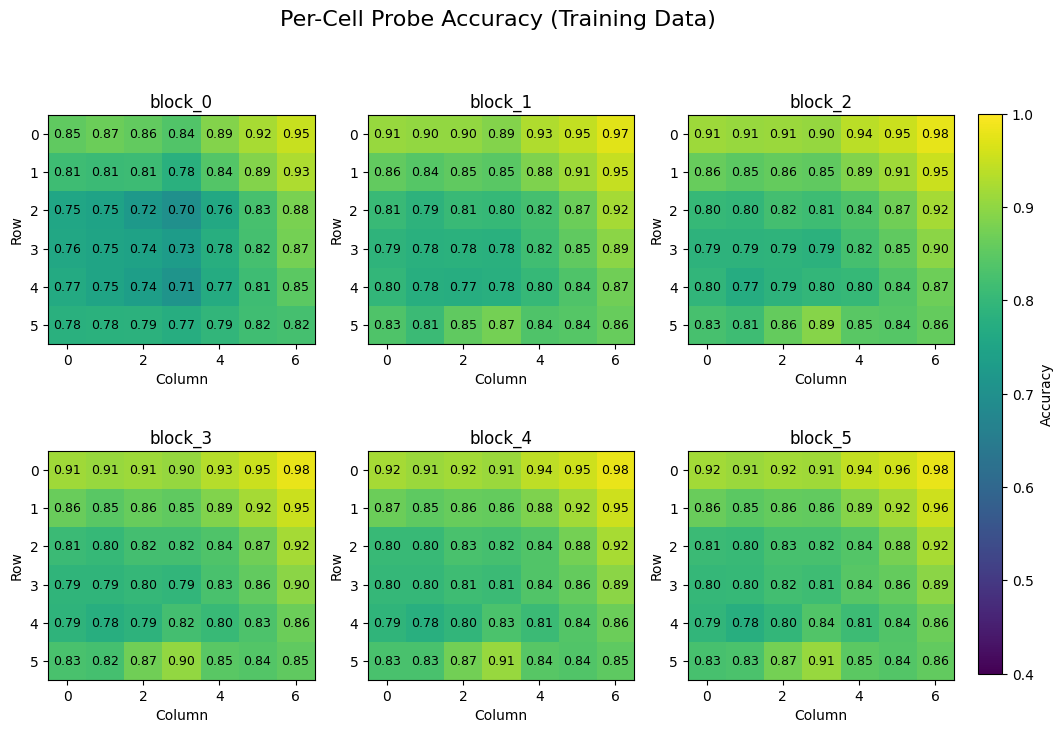

In [22]:
plot_heatmaps(train_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Training Data)', xlabel='Column', ylabel='Row')

In [23]:
val_acc_cell

{'block_0': tensor([0.8636, 0.8721, 0.8642, 0.8298, 0.8679, 0.9212, 0.9482, 0.8113, 0.8002,
         0.8076, 0.7685, 0.8340, 0.8858, 0.9255, 0.7516, 0.7267, 0.7045, 0.6966,
         0.7452, 0.8219, 0.8710, 0.7442, 0.7299, 0.7199, 0.7283, 0.7537, 0.8256,
         0.8605, 0.7606, 0.7558, 0.7484, 0.7389, 0.7817, 0.7933, 0.8293, 0.7748,
         0.7870, 0.7822, 0.7590, 0.8007, 0.8055, 0.7965], device='cuda:0'),
 'block_1': tensor([0.9022, 0.8975, 0.8975, 0.8858, 0.9117, 0.9376, 0.9672, 0.8473, 0.8367,
         0.8451, 0.8245, 0.8705, 0.8953, 0.9371, 0.8113, 0.7669, 0.7859, 0.7933,
         0.8050, 0.8531, 0.9160, 0.7690, 0.7569, 0.7590, 0.7664, 0.7965, 0.8462,
         0.8716, 0.7881, 0.7828, 0.7791, 0.7886, 0.8081, 0.8214, 0.8737, 0.8298,
         0.7976, 0.8372, 0.8684, 0.8409, 0.8272, 0.8377], device='cuda:0'),
 'block_2': tensor([0.9112, 0.8959, 0.8943, 0.8938, 0.9239, 0.9445, 0.9709, 0.8457, 0.8251,
         0.8446, 0.8330, 0.8705, 0.8932, 0.9445, 0.7849, 0.7854, 0.7970, 0.8060,
     

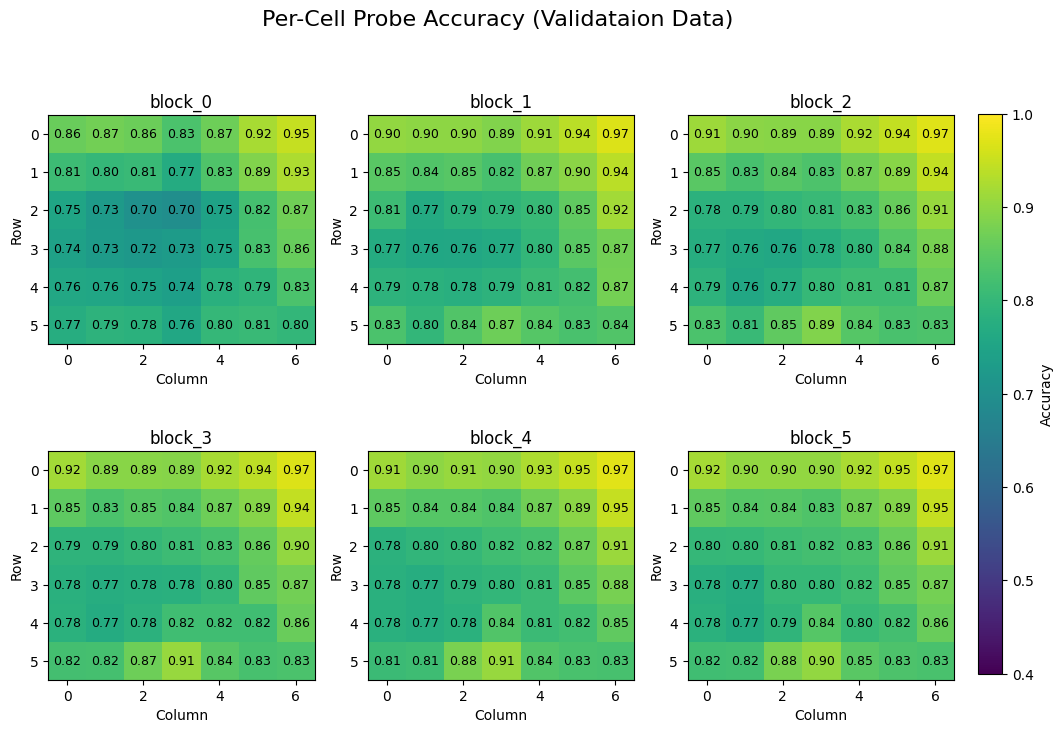

In [24]:
plot_heatmaps(val_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Validataion Data)', xlabel='Column', ylabel='Row')

Per column

In [25]:
train_acc_col, val_acc_col = eval_probe_results(col_probe_results, dim=train_Y_col.shape[-1])

In [26]:
train_acc_col

{'block_0': tensor([0.8038, 0.7981, 0.7966, 0.8139, 0.7775, 0.7963, 0.7896],
        device='cuda:0'),
 'block_1': tensor([0.9331, 0.9195, 0.9230, 0.9425, 0.9120, 0.9111, 0.8906],
        device='cuda:0'),
 'block_2': tensor([0.9317, 0.9220, 0.9276, 0.9434, 0.9122, 0.9138, 0.8944],
        device='cuda:0'),
 'block_3': tensor([0.9295, 0.9193, 0.9209, 0.9421, 0.9155, 0.9049, 0.8882],
        device='cuda:0'),
 'block_4': tensor([0.9308, 0.9172, 0.9223, 0.9433, 0.9138, 0.9074, 0.8835],
        device='cuda:0'),
 'block_5': tensor([0.9291, 0.9192, 0.9228, 0.9420, 0.9133, 0.9047, 0.8850],
        device='cuda:0')}

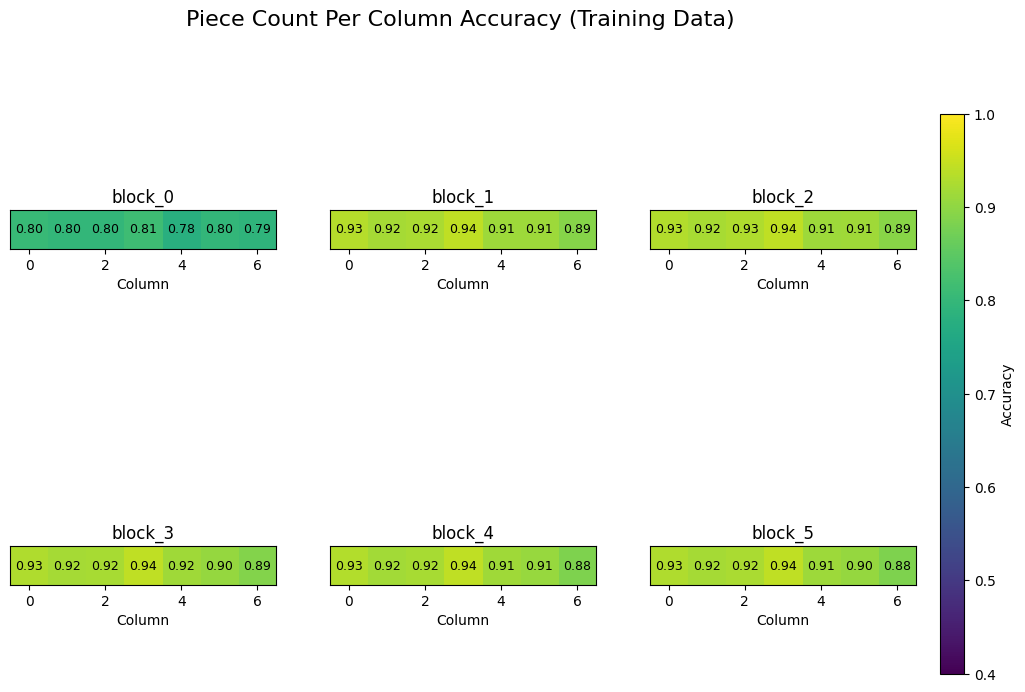

In [27]:
plot_heatmaps(train_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Training Data)', xlabel='Column', ylabel='', disable_yticks=True)

In [28]:
val_acc_col

{'block_0': tensor([0.7960, 0.7717, 0.7743, 0.7955, 0.7616, 0.7923, 0.7590],
        device='cuda:0'),
 'block_1': tensor([0.9138, 0.8990, 0.9070, 0.9286, 0.8985, 0.8985, 0.8621],
        device='cuda:0'),
 'block_2': tensor([0.9049, 0.8948, 0.9086, 0.9276, 0.9006, 0.8932, 0.8504],
        device='cuda:0'),
 'block_3': tensor([0.9043, 0.8922, 0.9038, 0.9281, 0.9086, 0.8790, 0.8414],
        device='cuda:0'),
 'block_4': tensor([0.9070, 0.8901, 0.8990, 0.9276, 0.9043, 0.8842, 0.8488],
        device='cuda:0'),
 'block_5': tensor([0.9064, 0.8927, 0.8948, 0.9244, 0.9054, 0.8753, 0.8372],
        device='cuda:0')}

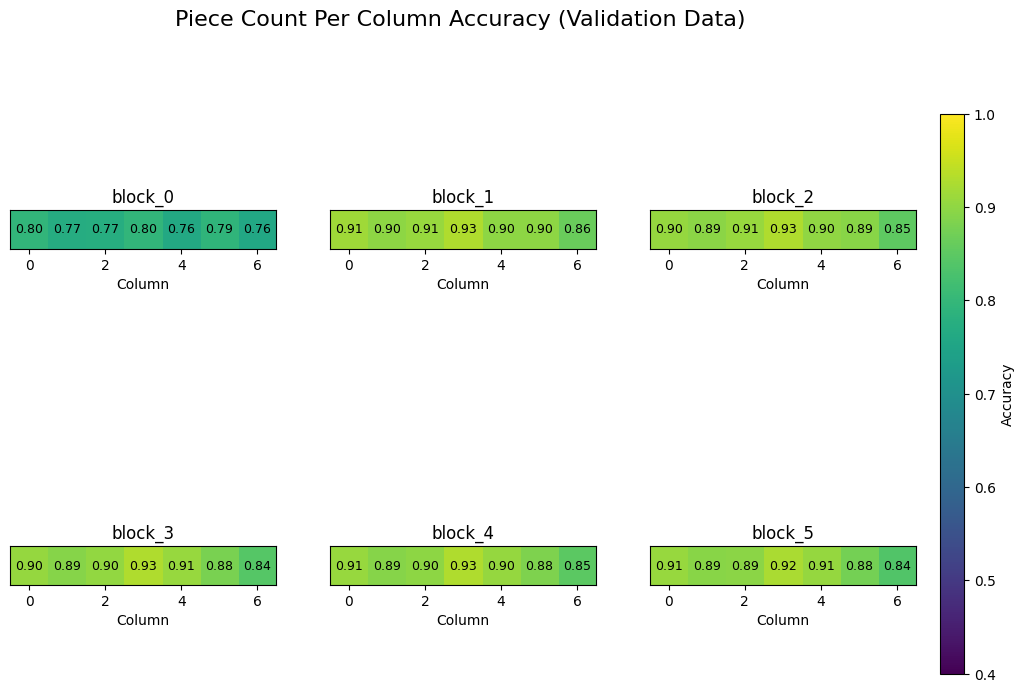

In [29]:
plot_heatmaps(val_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Validation Data)', xlabel='Column', ylabel='', disable_yticks=True)

Per row

In [30]:
train_acc_row, val_acc_row = eval_probe_results(row_probe_results, dim=train_Y_row.shape[-1])

In [31]:
train_acc_row

{'block_0': tensor([0.7472, 0.7212, 0.7081, 0.7222, 0.7336, 0.7569], device='cuda:0'),
 'block_1': tensor([0.8386, 0.7685, 0.7546, 0.7645, 0.7710, 0.8029], device='cuda:0'),
 'block_2': tensor([0.8794, 0.7717, 0.7715, 0.7710, 0.7678, 0.8061], device='cuda:0'),
 'block_3': tensor([0.8881, 0.7675, 0.7654, 0.7734, 0.7664, 0.8038], device='cuda:0'),
 'block_4': tensor([0.8865, 0.7726, 0.7675, 0.7736, 0.7648, 0.7995], device='cuda:0'),
 'block_5': tensor([0.8852, 0.7688, 0.7666, 0.7696, 0.7618, 0.7994], device='cuda:0')}

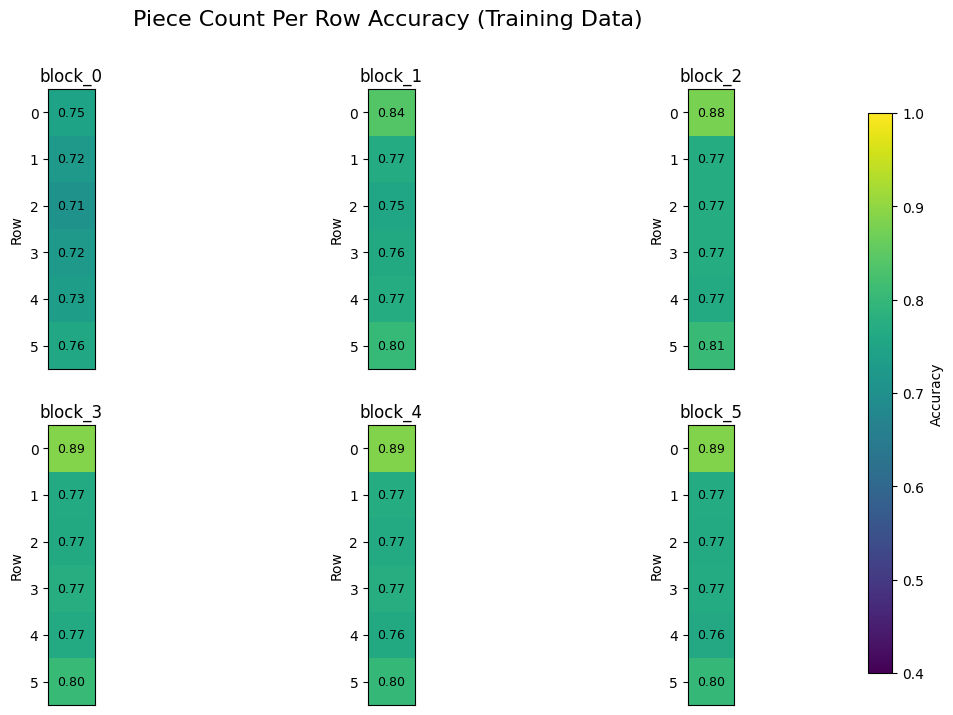

In [32]:
plot_heatmaps(train_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Training Data)', xlabel='', ylabel='Row', disable_xticks=True)

In [33]:
val_acc_row

{'block_0': tensor([0.7410, 0.7051, 0.6818, 0.7035, 0.7098, 0.7378], device='cuda:0'),
 'block_1': tensor([0.8214, 0.7320, 0.7326, 0.7320, 0.7331, 0.7733], device='cuda:0'),
 'block_2': tensor([0.8599, 0.7500, 0.7289, 0.7336, 0.7299, 0.7706], device='cuda:0'),
 'block_3': tensor([0.8732, 0.7352, 0.7304, 0.7378, 0.7289, 0.7659], device='cuda:0'),
 'block_4': tensor([0.8684, 0.7389, 0.7347, 0.7363, 0.7156, 0.7627], device='cuda:0'),
 'block_5': tensor([0.8668, 0.7357, 0.7225, 0.7410, 0.7119, 0.7632], device='cuda:0')}

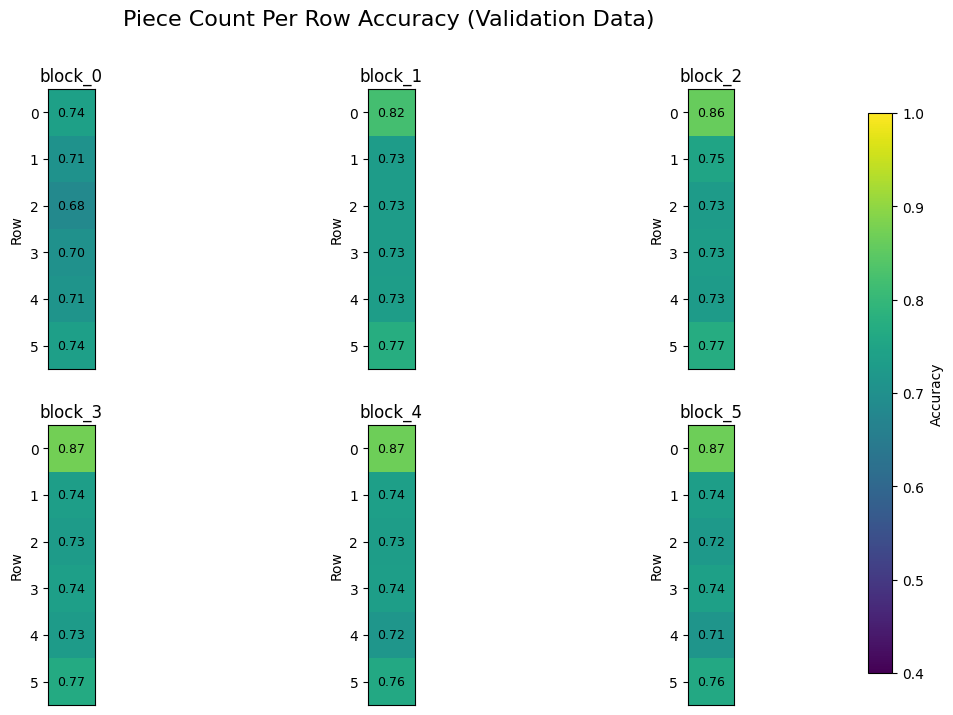

In [34]:
plot_heatmaps(val_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Validation Data)', xlabel='', ylabel='Row', disable_xticks=True)